In [19]:
using Revise
using LinearAlgebra
using LaTeXStrings
using TensorCrossInterpolation
import TensorCrossInterpolation: TensorCI, CachedFunction
import TensorCrossInterpolation as TCI
using Plots
using CSV 
using DataFrames 
using JLD2 
using Random 
using Tensor_FixedSeedMC 
import Tensor_FixedSeedMC as TCIMC
using Interpolations

In [20]:
# =============================================================================
# 3. TCI Method Evaluation for f(x,y)=sin(x+y) and Chebyshev Coefficients
# =============================================================================

# sin_ : Function for TCI; uses Chebyshev abscissas
function sin_(j::Vector{Int})
    z = [TCIMC.calc_cheby_abscissas(a, b, n)[i] for i in j]
    return sin(sum(z)) + randn() * level
end

function tci_oneshot(func, d, localdims, firstpivot, tol)
    BLAS.set_num_threads(4)
    for isearch in 1:100
        p = TCI.optfirstpivot(func, localdims, firstpivot)
        if abs(func(p)) > abs(func(firstpivot))
            firstpivot = p
        end
    end
    qtt, ranks, errors = TCI.crossinterpolate2(
        Float64,
        func,
        localdims,
        [firstpivot],
        tolerance = tol,
        maxiter = 6,
        verbosity = 1,
        loginterval = 1,
        pivotsearch = :rook,
    )
    return qtt, errors
end

# Domain & parameters for TCI evaluation
level = 10^(-2)
d = 2; 
#tol = 5 * 10^(-2); 
tol = 2 * 10^(-2); 
#tol = 10^(-4); 
a = 0.0; 
b = 2π; 
n = 30
localdims_p = collect(Iterators.flatten(zip(fill(n, d))))
firstpivot_p = collect(Iterators.flatten(zip(rand(1:n, d))))
Random.seed!(1234)
phi_(j) = sin_(j)
phi = TCI.CachedFunction{Float64}(phi_, localdims_p)

# Obtain tensor train for sin(x+y)
tt_sin_tci, errors_sin = tci_oneshot(phi, d, localdims_p, firstpivot_p, tol)

iteration = 1, rank = 29, error= 0.0, maxsamplevalue= 1.0238689161102168, nglobalpivot=0
iteration = 2, rank = 29, error= 0.0, maxsamplevalue= 1.0238689161102168, nglobalpivot=0
iteration = 3, rank = 29, error= 0.0, maxsamplevalue= 1.0238689161102168, nglobalpivot=0


(TensorCrossInterpolation.TensorCI2{Float64} with rank 29, [0.0, 0.0, 0.0])

In [21]:
tt_sin_tci.sitetensors

2-element Vector{Array{Float64, 3}}:
 [0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 1.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0]
 [-0.633594847051772 -0.6076660263707084 … -0.6656803209140844 -0.6367148373918334; -0.7314323568830936 -0.7447484209998261 … -0.6937348283823516 -0.7164185352967514; … ; 0.32450323282135246 0.36485101383875096 … 0.3015958594148971 0.3233118964927346; 0.9162969140651007 0.942276068178119 … 0.9053200325789271 0.9199472194789197;;;]

In [22]:
# Evaluate function values from tensor train
price_matrix_tci = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_tci[i,j] = TCIMC._evaluate(tt_sin_tci.sitetensors, [i, j])
end

cheb_nodes = TCIMC.calc_cheby_abscissas(a, b, n)

Random.seed!(1234)
price_matrix_sin_noise = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_sin_noise[i,j] = sin(cheb_nodes[i] + cheb_nodes[j]) + randn() * level
end

tol_svd = tol
US, Vt = TCI._factorize(price_matrix_sin_noise, :SVD; tolerance = tol_svd, maxbonddim=1000)
U_core = reshape(US, 1, size(US)[1], size(US)[2])
Vt_core = reshape(Vt, size(Vt)[1], size(Vt)[2], 1)

tt_svd = [U_core, Vt_core]
@show size(U_core)
@show size(Vt_core)


tt_sin_svd = TCI.TensorTrain(tt_svd)
#tt_sin_svd.sitetensors

price_matrix_svd = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_svd[i,j] = TCIMC._evaluate(tt_sin_svd.sitetensors, [i, j])
end


# Compute true sin(x+y) on Chebyshev nodes
price_matrix_sin = [ sin(cheb_nodes[i] + cheb_nodes[j]) for i in 1:n, j in 1:n ]
println("最大絶対誤差 (sin値, TCI vs true): ", maximum(abs.(price_matrix_sin .- price_matrix_tci)))
println("最大絶対誤差 (sin値, SVD vs true): ", maximum(abs.(price_matrix_sin .- price_matrix_svd)))

size(U_core) = (1, 30, 2)
size(Vt_core) = (2, 30, 1)
最大絶対誤差 (sin値, TCI vs true): 0.030902397255668203
最大絶対誤差 (sin値, SVD vs true): 0.01255124841984695


In [23]:
# (3) TCI法による x-微分評価（チェビシェフ微分基底を用いる）
#n = 50  # Chebyshev 展開次数
#C_coeff_tensor = C_mat_tci
M_dct = TCIMC.dct_matrix(n)
C_coeff_tensor_tci = TCIMC.compute_chebyshev_coeff(TensorTrain(tt_sin_tci.sitetensors), fill(M_dct, 2))
C_coeff_tensor_svd = TCIMC.compute_chebyshev_coeff(TensorTrain(tt_sin_svd.sitetensors), fill(M_dct, 2))

(::TensorTrain{Float64, 3}) (generic function with 1 method)

## original function

In [38]:
using Statistics, Random

# -------------------------------
# 1. グリッド設定
# -------------------------------
Nx = 100
Ny = 100
x_equi = range(a, stop=b, length=Nx)
y_equi = range(a, stop=b, length=Ny)
@show step(x_equi)
# 解析解: f(x,y)= sin(x+y) の x-微分は cos(x+y) 
f_true = [ sin(x + y) for x in x_equi, y in y_equi ]

# -------------------------------
# 2. 有限差分法 (FD)
# -------------------------------
# 各固定 y に対して、x方向の有限差分を計算
fd = zeros(Nx, Ny)
Random.seed!(1234)
for j in 1:Ny
    #Random.seed!(1234)
    f_col = [ sin(x + y_equi[j]) + randn() * level for x in x_equi ]
    for i in 2:(Nx-1)
        fd[i,j] = (f_col[i])
    end
end



# -------------------------------
# 4. TCI法による x-微分評価
# -------------------------------
# f(x,y)= sin(x+y) の Chebyshev展開に基づくテンソル列車近似から、x方向微分を評価
# Chebyshev展開次数 n を設定
f_tci = zeros(Nx, Ny)
for j in 1:Ny
    for i in 1:Nx
        x_val = x_equi[i]
        y_val = y_equi[j]
        # 各軸について、x軸は微分した基底、y軸は通常の基底を使用
        weights = [ TCIMC.chebyshev_basis(a, b, x_val, n),
        TCIMC.chebyshev_basis(a, b, y_val, n) ]
        c = 1  # 中央サイトのインデックス（ここでは 1）
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
        f_tci[i,j] = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
    end
end


# -------------------------------
# 5. SVD法による x-微分評価
# -------------------------------
# f(x,y)= sin(x+y) の Chebyshev展開に基づくテンソル列車近似から、x方向微分を評価
# Chebyshev展開次数 n を設定
f_svd = zeros(Nx, Ny)
for j in 1:Ny
    for i in 1:Nx
        x_val = x_equi[i]
        y_val = y_equi[j]
        # 各軸について、x軸は微分した基底、y軸は通常の基底を使用
        weights = [ TCIMC.chebyshev_basis(a, b, x_val, n),
        TCIMC.chebyshev_basis(a, b, y_val, n) ]
        c = 1  # 中央サイトのインデックス（ここでは 1）
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_svd, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_svd, weights, c)
        f_svd[i,j] = TCIMC.update_center(C_coeff_tensor_svd, left_cache, right_cache, weights[c], c)
    end
end

# -------------------------------
# 5. RMSE評価（内部領域からランダムに100点を選ぶ）
# -------------------------------
# 内部領域のインデックス（端点除く）
internal_indices_x = collect(2:(Nx-1))
internal_indices_y = collect(2:(Ny-1))
# 内部領域の全インデックス (i,j) のペアのリストを作成
internal_idx = [(i,j) for i in internal_indices_x, j in internal_indices_y]
internal_idx = vec(internal_idx)
# その中からランダムに100点を選ぶ
rand_internal = rand(internal_idx, 100)

# 各手法の RMSE を算出
get_rmse(mat) = sqrt(mean([ (mat[i,j] - f_true[i,j])^2 for (i,j) in rand_internal ]))
get_max(mat) = maximum(abs.(mat .- f_true))
rmse_f   = get_rmse(fd)
#rmse_cheb = get_rmse(df_cheb_equi)
rmse_tci  = get_rmse(f_tci)
rmse_svd  = get_rmse(f_svd)

@show "noise_leve", level
@show size(tt_sin_tci.sitetensors[1])
@show size(tt_sin_tci.sitetensors[2])
@show size(U_core)
@show size(Vt_core)

println("RMSE (内部): ", rmse_f)
#println("チェビシェフスペクトル法 RMSE (内部): ", rmse_cheb)
println("TCI法 RMSE (内部): ", rmse_tci)
println("SVD法 RMSE (内部): ", rmse_svd)

@show "最大絶対誤差 (TCI法 vs true): ", get_max(f_tci)
println("最大絶対誤差 (SVD法 vs true): ", get_max(f_svd))
println("最大絶対誤差 (FD法 vs true): ", get_max(fd))

step(x_equi) = 0.06346651825433926
("noise_leve", level) = ("noise_leve", 0.010000000000000002)
size(tt_sin_tci.sitetensors[1]) = (1, 30, 29)
size(tt_sin_tci.sitetensors[2]) = (29, 30, 1)
size(U_core) = (1, 30, 2)
size(Vt_core) = (2, 30, 1)
RMSE (内部): 0.00918327188818681
TCI法 RMSE (内部): 0.010334186896597585
SVD法 RMSE (内部): 0.002920858677000922
("最大絶対誤差 (TCI法 vs true): ", get_max(f_tci)) = ("最大絶対誤差 (TCI法 vs true): ", 0.03586850076668752)
最大絶対誤差 (SVD法 vs true): 0.01462208648183072
最大絶対誤差 (FD法 vs true): 0.9998741276738751


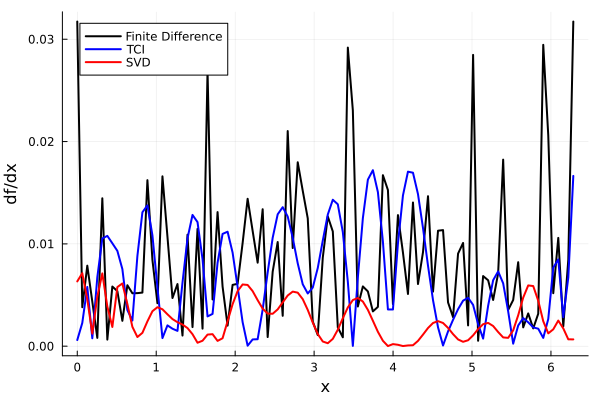

In [25]:
using Plots

# (前提) すでに
#   Nx, Ny, x_equi, y_equi
#   df_true, df_fd, df_tci
# などが定義・計算済みとする

# 可視化したい行（例えば j=50 の y方向）を指定
j_plot = 50

# x軸 = x_equi、各 x点での微分値をプロット
# 真の微分 (df_true)
# 有限差分法 (df_fd)
# TCI法 (df_tci)
p = plot(
    x_equi,
    abs.(f_true[:, j_plot] .- fd[:, j_plot]),
    label="Finite Difference",
    linewidth=2,
    color=:black,
    xlabel="x",
    ylabel="df/dx"
)

plot!(
    x_equi,
    abs.(f_true[:, j_plot] .- f_tci[:, j_plot]),
    label="TCI",
    linewidth=2,
    color=:blue
)

plot!(
    x_equi,
    abs.(f_true[:, j_plot] .- f_svd[:, j_plot]),
    label="SVD",
    linewidth=2,
    color=:red
)

# グラフを表示
display(p)

In [26]:
using JLD2
@save "../data_/sin_tol$tol.jld2" x_equi f_true fd f_tci f_svd


# first derivative

In [27]:
# =============================================================================
# 4. Derivative Comparisons: Finite Difference, Chebyshev Spectral, TCI-based
# =============================================================================
# 固定 y = 0 として f(x,y) = sin(x) の x-微分を各手法で評価し、解析解 cos(x) と比較

Nx = n 
x_equi = range(a, stop=b, length=Nx)
y_fixed = 0.0 
df_true = [ cos(x + y_fixed) for x in x_equi ]  # 解析解

N_cheb = n
x_cheb, D_cheb = TCIMC.cheb_nodes_and_diffmat(N_cheb)


([1.0, 0.9945218953682733, 0.9781476007338057, 0.9510565162951535, 0.9135454576426009, 0.8660254037844387, 0.8090169943749475, 0.7431448254773944, 0.6691306063588582, 0.5877852522924731  …  -0.587785252292473, -0.6691306063588579, -0.7431448254773941, -0.8090169943749473, -0.8660254037844385, -0.9135454576426008, -0.9510565162951535, -0.9781476007338056, -0.9945218953682733, -1.0], [300.16666666666333 -365.0897772957644 … -1.00274657532938 0.5; 91.2724443239411 -45.51087884005363 … 0.5027541397817582 -0.250686643832345; … ; 0.250686643832345 -0.5027541397817582 … 45.51087884005405 -91.2724443239411; -0.5 1.00274657532938 … 365.0897772957644 -300.1666666666638])

## 100点で計算

In [29]:
using Statistics, Random

# -------------------------------
# 1. グリッド設定
# -------------------------------
Nx = 100
Ny = 100
x_equi = range(a, stop=b, length=Nx)
y_equi = range(a, stop=b, length=Ny)
@show step(x_equi)
# 解析解: f(x,y)= sin(x+y) の x-微分は cos(x+y) 
df_true = [ cos(x + y) for x in x_equi, y in y_equi ]

# -------------------------------
# 2. 有限差分法 (FD)
# -------------------------------
# 各固定 y に対して、x方向の有限差分を計算
df_fd = zeros(Nx, Ny)
Random.seed!(1234)
for j in 1:Ny
    #Random.seed!(1234)
    f_col = [ sin(x + y_equi[j]) + randn() * level for x in x_equi ]
    df_fd[1,j]   = (f_col[2] - f_col[1]) / step(x_equi)
    df_fd[Nx,j]  = (f_col[Nx] - f_col[Nx-1]) / step(x_equi)
    for i in 2:(Nx-1)
        df_fd[i,j] = (f_col[i+1] - f_col[i-1]) / (2*step(x_equi))
    end
end



# -------------------------------
# 4. TCI法による x-微分評価
# -------------------------------
# f(x,y)= sin(x+y) の Chebyshev展開に基づくテンソル列車近似から、x方向微分を評価
# Chebyshev展開次数 n を設定
df_tci = zeros(Nx, Ny)
for j in 1:Ny
    for i in 1:Nx
        x_val = x_equi[i]
        y_val = y_equi[j]
        # 各軸について、x軸は微分した基底、y軸は通常の基底を使用
        weights = [ TCIMC.chebyshev_basis_derivative(a, b, x_val, n),
        TCIMC.chebyshev_basis(a, b, y_val, n) ]
        c = 1  # 中央サイトのインデックス（ここでは 1）
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
        df_tci[i,j] = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
    end
end


# -------------------------------
# 5. SVD法による x-微分評価
# -------------------------------
# f(x,y)= sin(x+y) の Chebyshev展開に基づくテンソル列車近似から、x方向微分を評価
# Chebyshev展開次数 n を設定
df_svd = zeros(Nx, Ny)
for j in 1:Ny
    for i in 1:Nx
        x_val = x_equi[i]
        y_val = y_equi[j]
        # 各軸について、x軸は微分した基底、y軸は通常の基底を使用
        weights = [ TCIMC.chebyshev_basis_derivative(a, b, x_val, n),
        TCIMC.chebyshev_basis(a, b, y_val, n) ]
        c = 1  # 中央サイトのインデックス（ここでは 1）
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_svd, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_svd, weights, c)
        df_svd[i,j] = TCIMC.update_center(C_coeff_tensor_svd, left_cache, right_cache, weights[c], c)
    end
end

# -------------------------------
# 5. RMSE評価（内部領域からランダムに100点を選ぶ）
# -------------------------------
# 内部領域のインデックス（端点除く）
internal_indices_x = collect(2:(Nx-1))
internal_indices_y = collect(2:(Ny-1))
# 内部領域の全インデックス (i,j) のペアのリストを作成
internal_idx = [(i,j) for i in internal_indices_x, j in internal_indices_y]
internal_idx = vec(internal_idx)
# その中からランダムに100点を選ぶ
rand_internal = rand(internal_idx, 100)

# 各手法の RMSE を算出
get_rmse(mat) = sqrt(mean([ (mat[i,j] - df_true[i,j])^2 for (i,j) in rand_internal ]))

rmse_fd   = get_rmse(df_fd)
#rmse_cheb = get_rmse(df_cheb_equi)
rmse_tci  = get_rmse(df_tci)
rmse_svd  = get_rmse(df_svd)

println("有限差分法 RMSE (内部): ", rmse_fd)
#println("チェビシェフスペクトル法 RMSE (内部): ", rmse_cheb)
println("TCI法 RMSE (内部): ", rmse_tci)
println("SVD法 RMSE (内部): ", rmse_svd)

step(x_equi) = 0.06346651825433926
有限差分法 RMSE (内部): 0.12461659446824597
TCI法 RMSE (内部): 0.07901711197067503
SVD法 RMSE (内部): 0.028389192501221055


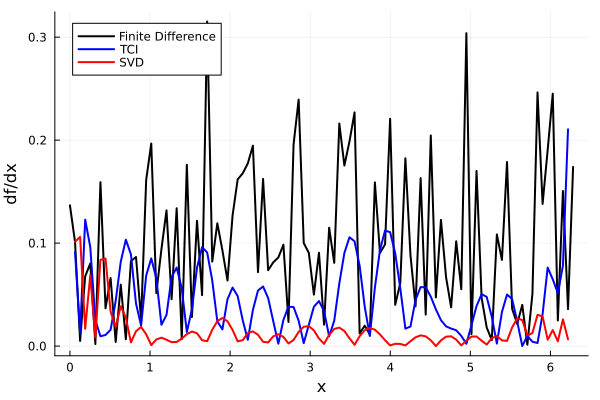

In [30]:
using Plots

# (前提) すでに
#   Nx, Ny, x_equi, y_equi
#   df_true, df_fd, df_tci
# などが定義・計算済みとする

# 可視化したい行（例えば j=50 の y方向）を指定
j_plot = 50

# x軸 = x_equi、各 x点での微分値をプロット
# 真の微分 (df_true)
# 有限差分法 (df_fd)
# TCI法 (df_tci)
p = plot(
    x_equi,
    abs.(df_true[:, j_plot] .- df_fd[:, j_plot]),
    label="Finite Difference",
    linewidth=2,
    color=:black,
    xlabel="x",
    ylabel="df/dx"
)
plot!(
    x_equi,
    abs.(df_true[:, j_plot] .- df_tci[:, j_plot]),
    label="TCI",
    linewidth=2,
    color=:blue
)

plot!(
    x_equi,
    abs.(df_true[:, j_plot] .- df_svd[:, j_plot]),
    label="SVD",
    linewidth=2,
    color=:red
)

# グラフを表示
display(p)


In [31]:
using JLD2

@save "../data_/sin_first_derivative_tol$tol.jld2" x_equi df_true df_fd df_tci df_svd j_plot


## 2回微分

In [32]:
using Statistics, Random

# -------------------------------
# 1. グリッド設定
# -------------------------------
Nx = 100
Ny = 100
x_equi = range(a, stop=b, length=Nx)
y_equi = range(a, stop=b, length=Ny)
@show step(x_equi)
# 解析解: f(x,y)= sin(x+y) の x-微分は cos(x+y) 
df2_true = [ -sin(x + y) for x in x_equi, y in y_equi ]

# -------------------------------
# 2. 有限差分法 (FD)
# -------------------------------
# 各固定 y に対して、x方向の有限差分を計算
df2_fd = zeros(Nx, Ny)
Random.seed!(1234)
for j in 1:Ny
    #Random.seed!(1234)
    f_col = [ sin(x + y_equi[j]) + randn() * level for x in x_equi ]
    df2_fd[1,j]   =  (f_col[2] - 2*f_col[1] + f_col[2]) / (step(x_equi)^2)
    df2_fd[Nx,j]  = (f_col[end-1] - 2*f_col[end] + f_col[end-1]) / (step(x_equi)^2)
    for i in 2:(Nx-1)
        df2_fd[i,j] = (f_col[i+1] - 2*f_col[i] + f_col[i-1]) / (step(x_equi)^2)
    end
end

step(x_equi) = 0.06346651825433926


In [33]:
# -------------------------------
# 4. TCI法による x-微分評価
# -------------------------------
# f(x,y)= sin(x+y) の Chebyshev展開に基づくテンソル列車近似から、x方向微分を評価
# Chebyshev展開次数 n を設定
df2_tci = zeros(Nx, Ny)
for j in 1:Ny
    for i in 1:Nx
        x_val = x_equi[i]
        y_val = y_equi[j]
        # 各軸について、x軸は微分した基底、y軸は通常の基底を使用
        weights = [ TCIMC.chebyshev_basis_second_derivative(a, b, x_val, n),
        TCIMC.chebyshev_basis(a, b, y_val, n) ]
        c = 1  # 中央サイトのインデックス（ここでは 1）
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
        df2_tci[i,j] = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
    end
end


# -------------------------------
# 5. SVD法による x-微分評価
# -------------------------------
# f(x,y)= sin(x+y) の Chebyshev展開に基づくテンソル列車近似から、x方向微分を評価
# Chebyshev展開次数 n を設定
df2_svd = zeros(Nx, Ny)
for j in 1:Ny
    for i in 1:Nx
        x_val = x_equi[i]
        y_val = y_equi[j]
        # 各軸について、x軸は微分した基底、y軸は通常の基底を使用
        weights = [ TCIMC.chebyshev_basis_second_derivative(a, b, x_val, n),
        TCIMC.chebyshev_basis(a, b, y_val, n) ]
        c = 1  # 中央サイトのインデックス（ここでは 1）
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_svd, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_svd, weights, c)
        df2_svd[i,j] = TCIMC.update_center(C_coeff_tensor_svd, left_cache, right_cache, weights[c], c)
    end
end


# -------------------------------
# 5. RMSE評価（内部領域からランダムに100点を選ぶ）
# -------------------------------
# 内部領域のインデックス（端点除く）
internal_indices_x = collect(2:(Nx-1))
internal_indices_y = collect(2:(Ny-1))
# 内部領域の全インデックス (i,j) のペアのリストを作成
internal_idx = [(i,j) for i in internal_indices_x, j in internal_indices_y]
internal_idx = vec(internal_idx)
# その中からランダムに100点を選ぶ
rand_internal = rand(internal_idx, 100)

# 各手法の RMSE を算出
get_rmse(mat) = sqrt(mean([ (mat[i,j] - df2_true[i,j])^2 for (i,j) in rand_internal ]))

rmse_fd2   = get_rmse(df2_fd)
#rmse_cheb = get_rmse(df_cheb_equi)
rmse_tci2  = get_rmse(df2_tci)
rmse_svd2  = get_rmse(df2_svd)

println("有限差分法 RMSE (内部): ", rmse_fd2)
#println("チェビシェフスペクトル法 RMSE (内部): ", rmse_cheb)
println("TCI法 RMSE (内部): ", rmse_tci2)
println("SVD法 RMSE (内部): ", rmse_svd2)


有限差分法 RMSE (内部): 5.614247977807376
TCI法 RMSE (内部): 1.201380233390253
SVD法 RMSE (内部): 0.3448228362175076


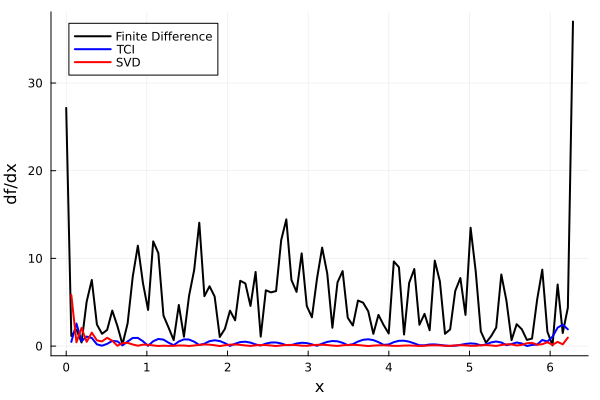

In [34]:
using Plots

# (前提) すでに
#   Nx, Ny, x_equi, y_equi
#   df_true, df_fd, df_tci
# などが定義・計算済みとする

# 可視化したい行（例えば j=50 の y方向）を指定
j_plot = 50

# x軸 = x_equi、各 x点での微分値をプロット
# 真の微分 (df_true)
# 有限差分法 (df_fd)
# TCI法 (df_tci)
p = plot(
    x_equi,
    abs.(df2_true[:, j_plot] .- df2_fd[:, j_plot]),
    label="Finite Difference",
    linewidth=2,
    color=:black,
    xlabel="x",
    ylabel="df/dx"
)
plot!(
    x_equi,
    abs.(df2_true[:, j_plot] .- df2_tci[:, j_plot]),
    label="TCI",
    linewidth=2,
    color=:blue
)

plot!(
    x_equi,
    abs.(df2_true[:, j_plot] .- df2_svd[:, j_plot]),
    label="SVD",
    linewidth=2,
    color=:red
)

# グラフを表示
display(p)

In [ ]:
using JLD2
@save "../data_/sin_second_derivative_tol$tol.jld2" x_equi df2_true df2_fd df2_tci df2_svd j_plot
